In [16]:
%matplotlib inline
import numpy as np
from sklearn.model_selection import train_test_split
from pprint import pprint
from data import Data
from classifier import fit_clf
from classifier import evaluate
from features import feature_report
from features import get_features
from features import weight_summary
from IPython.display import display

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### I. Loading Data

In [17]:
#Load Data

%autoreload

data = Data()

X = data.get_X()
X_malware = data.get_X_malware()
X_goodware= data.get_X_goodware()
Y = data.get_Y()
feature_names = data.get_feature_names()

print(f'X.shape: {X.shape}')
print(f'Y.shape: {Y.shape}')
print(f'Number of features: {len(feature_names)}')

Starting to read the data shelf
Finished reading the data shelf. Elapsed time: 0.012152106666666404 minutes
X.shape: (129728, 1140816)
Y.shape: (129728,)
Number of features: 1140816


### II. Training, Testing, and Evaluation

In [18]:
# Split

test_size = 0.3
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,
                                                    stratify=Y,random_state=0)

In [19]:
# Fit a classifier

clf = fit_clf(X_train, Y_train, tune=False)
# Get model parameters
pprint(vars(clf))
weights = clf.coef_.flatten()
intercept = clf.intercept_[0]

SVM-C1 Loaded
{'C': 1.0,
 'class_weight': None,
 'classes_': array([0, 1], dtype=uint8),
 'coef_': array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.07378635]]),
 'dual': True,
 'fit_intercept': True,
 'intercept_': array([-1.29122964]),
 'intercept_scaling': 1,
 'loss': 'hinge',
 'max_iter': 1000000,
 'multi_class': 'ovr',
 'n_iter_': 67310,
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 1}


CLF Evaluation on the Test Set
Classification Report:
               precision    recall  f1-score   support

     Malware       0.92      0.90      0.91      3821
    Goodware       0.99      0.99      0.99     35098

    accuracy                           0.98     38919
   macro avg       0.95      0.94      0.95     38919
weighted avg       0.98      0.98      0.98     38919

[TP, FN, FP, TN] = [3421, 400, 309, 34789]


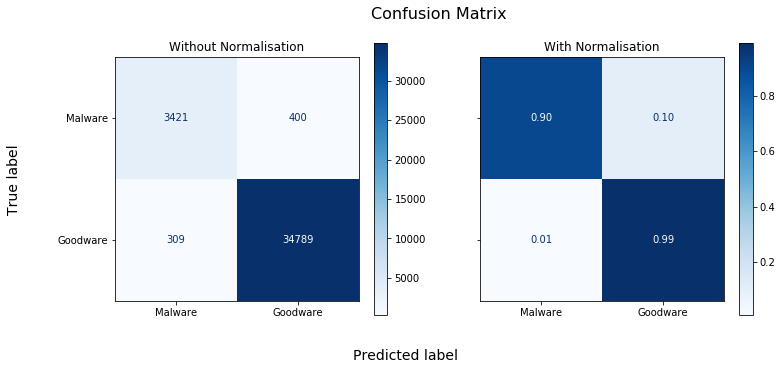

In [20]:
# Evaluate the classifier on the Test Set

print("CLF Evaluation on the Test Set")
evaluate(model=clf, X=X_test, Y_true=Y_test)

CLF Evaluation on the Training Set (for the Resubsitution Error)
Classification Report:
               precision    recall  f1-score   support

     Malware       1.00      0.98      0.99      8914
    Goodware       1.00      1.00      1.00     81895

    accuracy                           1.00     90809
   macro avg       1.00      0.99      0.99     90809
weighted avg       1.00      1.00      1.00     90809

[TP, FN, FP, TN] = [8778, 136, 36, 81859]


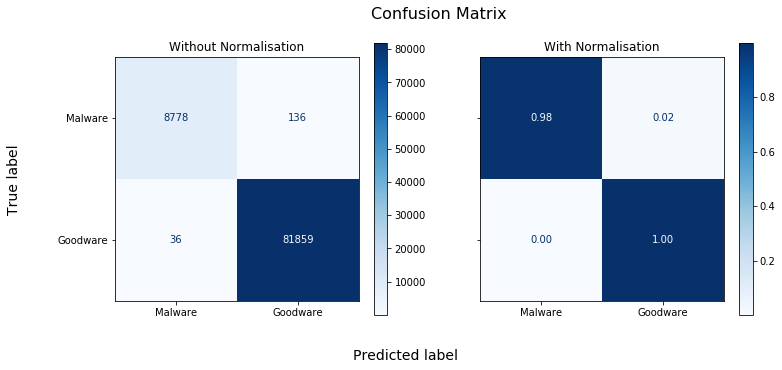

In [21]:
# Evaluate the classifier the Training Set (Resubsitution Error)

print("CLF Evaluation on the Training Set (for the Resubsitution Error)")
evaluate(model=clf, X=X_train, Y_true=Y_train)

In [22]:
# Get all true positives from both training & test sets
Y_pred = clf.predict(X_malware)
# Correctly classified (TP) malware (seeds for the evasion attacks)
TP_malware = X_malware[np.flatnonzero(Y_pred)]
print(f'All malware: {X_malware.shape[0]}')
print(f'TP malware: {TP_malware.shape[0]} '
      f'({100*TP_malware.shape[0]/X_malware.shape[0]:.2f}%)')

F_pred = clf.decision_function(TP_malware)
print(f'Decision function values for TP malware:\n{F_pred}')


All malware: 12735
TP malware: 12199 (95.79%)
Decision function values for TP malware:
[0.99999962 1.00000067 4.65086048 ... 1.8004033  5.15136459 2.42023043]


### III. Feature Analysis

In [23]:
# 1. Construct a features dataframe
%autoreload

features = get_features(feature_names, weights, X, X_malware, X_goodware, Y)

print('1. Dataframe of all features\n')
print(f'Columns:\n--------\n'
      f'0 {"idx":<10} => Index\n'
      f'1 {"feature":<10} => Feature name\n'
      f'2 {"weight":<10} => Feature weight in the trained model\n'
      f'3 {"all_freq":<10} => P(x|D) The normalised frequency of the feature in the whole dataset\n'
      f'4 {"mal_freq":<10} => P(x|malware) The normalised frequency of the feature in the malware class\n'
      f'5 {"good_freq":<10} => P(x|goodware) The normalised frequency of the feature in the goodware class\n'
      f'6 {"chi2":<10} => The chi^2 value to measure the independence between features and classes (for feature selection)\n')

display(features)

1. Dataframe of all features

Columns:
--------
0 idx        => Index
1 feature    => Feature name
2 weight     => Feature weight in the trained model
3 all_freq   => P(x|D) The normalised frequency of the feature in the whole dataset
4 mal_freq   => P(x|malware) The normalised frequency of the feature in the malware class
5 good_freq  => P(x|goodware) The normalised frequency of the feature in the goodware class
6 chi2       => The chi^2 value to measure the independence between features and classes (for feature selection)



feature    weight  \
0                                     activities::#Pray714  0.000000   
1                                      activities::$Viewer  0.000000   
2                                            activities::%  0.000000   
3                                      activities::* HPROF  0.000000   
4                                 activities::*** Menu ***  0.000000   
...                                                    ...       ...   
1140811              urls::https://zurich_api_medallia_eu/  0.000000   
1140812                          urls::https://zurvita_com  0.000000   
1140813  urls::https://zurvita_sd_success_com/account/l...  0.000000   
1140814                         urls::https://zuul_your_md  0.000000   
1140815  urls::https://zxing_googlecode_com/files/Barco...  0.073786   

         all_freq  mal_freq  good_freq      chi2  
0        0.000008  0.000000   0.000009  0.108853  
1        0.000008  0.000000   0.000009  0.108853  
2        0.000008  0.000000   0.000009  0.108853  
3        0.000023  0.000000   0.000026  0.326558  
4        0.000008  0.000000   0.000009  0.108853  
...           ...       ...        ...       ...  
1140811  0.000008  0.000000   0.000009  0.108853  
1140812  0.000008  0.000000   0.000009  0.108853  
1140813  0.000008  0.000000   0.000009  0.108853  
1140814  0.000008  0.000000   0.000009  0.108853  
1140815  0.000054  0.000079   0.000051  0.157918  

[1140816 rows x 6 columns]

In [24]:
# 2. Rank features by chi2, for feature selection
features_by_chi2 = features.sort_values(by='chi2', ascending=False)
top = 50000
print(f'2. Features ranked by chi^2 (top {top})\n')
print('[Note the difference between the two distributions: mal_freq=P(x|M) vs good_freq=P(x|G)]\n')
display(features_by_chi2.head(top))

2. Features ranked by chi^2 (top 50000)

[Note the difference between the two distributions: mal_freq=P(x|M) vs good_freq=P(x|G)]



feature    weight  \
523239         intents::android_intent_action_USER_PRESENT  1.003330   
480088   app_permissions::name='android_permission_SYST...  0.375718   
522202        intents::android_intent_action_PACKAGE_ADDED  0.388221   
483552   app_permissions::name='com_android_launcher_pe...  0.338446   
479740   app_permissions::name='android_permission_GET_...  0.135907   
...                                                    ...       ...   
292312   activities::com_namcobandaigames_dragonballtap...  0.000000   
511822   app_permissions::name='com_wShoppingATXcom_per...  0.811073   
511823   app_permissions::name='com_wShoppingAppIndia99...  0.169201   
1051034  urls::https://github_com/balesz/android-tutori...  0.000000   
773980       urls::http://mob_mamiduo_com/snsn/index1_aspx  0.012357   

         all_freq  mal_freq  good_freq          chi2  
523239   0.087421  0.495406   0.043011  26887.073231  
480088   0.114933  0.563094   0.066149  24677.269176  
522202   0.073022  0.394896   0.037985  20035.058466  
483552   0.069553  0.367256   0.037148  17993.686961  
479740   0.149297  0.576521   0.102792  17263.698875  
...           ...       ...        ...           ...  
292312   0.000008  0.000079   0.000000      9.186729  
511822   0.000008  0.000079   0.000000      9.186729  
511823   0.000008  0.000079   0.000000      9.186729  
1051034  0.000008  0.000079   0.000000      9.186729  
773980   0.000008  0.000079   0.000000      9.186729  

[50000 rows x 6 columns]

In [25]:
# 3.1 Features with non-zero weights
nz_features = features.loc[features.weight != 0]
print(f'\n3.1 Features with non-zero weights '
      f'({nz_features.shape[0]}/{features.shape[0]} = '
      f'{nz_features.shape[0]/features.shape[0]*100:.2f}%)\n')

print('[Only these features contribute to the output of the decision function]\n')

display(nz_features)


3.1 Features with non-zero weights (156629/1140816 = 13.73%)

[Only these features contribute to the output of the decision function]



feature    weight  \
19                                      activities::/blogs -0.002852   
145                   activities::1Fakt: Test Inteligjence  0.166948   
150                 activities::200 Free Mix Wallpapers HD -0.781470   
204                     activities::24 Best Firefox Addons -0.013916   
390                                activities::3D Pal Lite -0.000585   
...                                                    ...       ...   
1140765  urls::https://zirconia_samsungapps_com:443/chk...  0.120881   
1140776     urls::https://zmopenapi_zmxy_com_cn/openapi_do -0.038590   
1140777      urls::https://zmopenapi_zmxy_com_cn/zmsdk_htm -0.038590   
1140784                              urls::https://zoom_us -0.005992   
1140815  urls::https://zxing_googlecode_com/files/Barco...  0.073786   

         all_freq  mal_freq  good_freq       chi2  
19       0.000015  0.000000   0.000017   0.217705  
145      0.000008  0.000079   0.000000   9.186729  
150      0.000008  0.000000   0.000009   0.108853  
204      0.000008  0.000000   0.000009   0.108853  
390      0.000008  0.000000   0.000009   0.108853  
...           ...       ...        ...        ...  
1140765  0.000224  0.000864   0.000154  25.891811  
1140776  0.000023  0.000157   0.000009  10.951924  
1140777  0.000023  0.000157   0.000009  10.951924  
1140784  0.000031  0.000000   0.000034   0.435411  
1140815  0.000054  0.000079   0.000051   0.157918  

[156629 rows x 6 columns]

3.2 The distribution of non-zero weights

[To see whether the features are evenly weighted]



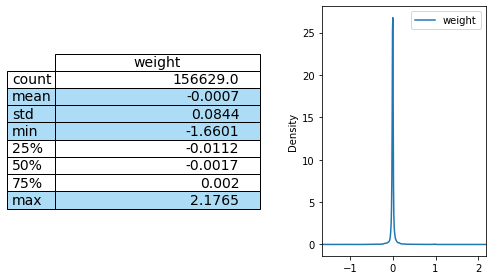

In [26]:
%autoreload
# 3.2 Weight distribution
print("3.2 The distribution of non-zero weights\n")
print('[To see whether the features are evenly weighted]\n')
weight_summary(nz_features)

In [27]:
# 3.3 Rank non-zero features by the magnitude of weights (absolute values)
ranked_idx = np.argsort(abs(nz_features.weight)).values[::-1]
abs_features = nz_features.iloc[ranked_idx]
top = 50000
print(f'\n3.3. Top {top} features, '
      f'Ranked by weight magnitude (absolute values)\n')

print("[For a linear SVM, these weights correspond to the largest partial derivatives of the decision function]\n")

display(abs_features.head(top))


3.3. Top 50000 features, Ranked by weight magnitude (absolute values)

[For a linear SVM, these weights correspond to the largest partial derivatives of the decision function]



feature    weight  \
512655   app_permissions::name='com_xiaomi_sdk_permissi...  2.176544   
1093746  urls::https://play_google_com/store/apps/devel...  2.000000   
308433   activities::com_phonegap_plugins_videoplayer_S...  2.000000   
176708   activities::com_digitalborder_webappessentials...  1.987180   
138573    activities::com_bangcle_everisk_stub_NewActivity  1.817333   
...                                                    ...       ...   
495318   app_permissions::name='com_godo_com_permission... -0.016248   
211354     activities::com_godosoft_eyelook_EyeLookScreen2 -0.016248   
211352    activities::com_godosoft_eyelook_EyeLookActivity -0.016248   
777081     urls::http://mobileapp_godo_co_kr/new/index_php -0.016248   
697197                             urls::http://godo_co_kr -0.016248   

         all_freq  mal_freq  good_freq        chi2  
512655   0.000416  0.004162   0.000009  475.919111  
1093746  0.000015  0.000157   0.000000   18.373459  
308433   0.000031  0.000314   0.000000   36.746918  
176708   0.000031  0.000236   0.000009   19.197355  
138573   0.000493  0.005026   0.000000  587.950687  
...           ...       ...        ...         ...  
495318   0.000008  0.000000   0.000009    0.108853  
211354   0.000008  0.000000   0.000009    0.108853  
211352   0.000008  0.000000   0.000009    0.108853  
777081   0.000008  0.000000   0.000009    0.108853  
697197   0.000008  0.000000   0.000009    0.108853  

[50000 rows x 6 columns]

In [28]:
# 3.4 Rank features with positive weights
pos_features = nz_features.loc[nz_features.weight > 0]
pos_features = pos_features.sort_values(by='weight', ascending=False)
top = 50000
print(f'\n5. Top {top} positive features (out of {pos_features.shape[0]}), '
      f'Ranked by weight\n')

print("[These weights correspond to the largest partial derivatives towards the malware class]\n")

display(pos_features.head(top))


5. Top 50000 positive features (out of 50226), Ranked by weight

[These weights correspond to the largest partial derivatives towards the malware class]



feature        weight  \
512655   app_permissions::name='com_xiaomi_sdk_permissi...  2.176544e+00   
1093746  urls::https://play_google_com/store/apps/devel...  2.000000e+00   
308433   activities::com_phonegap_plugins_videoplayer_S...  2.000000e+00   
176708   activities::com_digitalborder_webappessentials...  1.987180e+00   
138573    activities::com_bangcle_everisk_stub_NewActivity  1.817333e+00   
...                                                    ...           ...   
1062647  urls::https://lh6_googleusercontent_com/-KGBWQ...  8.131516e-20   
1062819  urls::https://lh6_googleusercontent_com/-anBgi...  8.131516e-20   
1062640  urls::https://lh6_googleusercontent_com/-JmS8S...  8.131516e-20   
1062638  urls::https://lh6_googleusercontent_com/-JBWUT...  8.131516e-20   
1062637  urls::https://lh6_googleusercontent_com/-JBWUT...  8.131516e-20   

         all_freq  mal_freq  good_freq        chi2  
512655   0.000416  0.004162   0.000009  475.919111  
1093746  0.000015  0.000157   0.000000   18.373459  
308433   0.000031  0.000314   0.000000   36.746918  
176708   0.000031  0.000236   0.000009   19.197355  
138573   0.000493  0.005026   0.000000  587.950687  
...           ...       ...        ...         ...  
1062647  0.000015  0.000000   0.000017    0.217705  
1062819  0.000015  0.000000   0.000017    0.217705  
1062640  0.000015  0.000000   0.000017    0.217705  
1062638  0.000015  0.000000   0.000017    0.217705  
1062637  0.000015  0.000000   0.000017    0.217705  

[50000 rows x 6 columns]

In [29]:
# 3.5 Rank features with positive weights
neg_features = nz_features.loc[nz_features.weight < 0]
neg_features = neg_features.sort_values(by='weight', ascending=True)
top = 50000
print(f'\n6. Top {top} negative features (out of {neg_features.shape[0]}), '
      f'Ranked by weight\n')

print("[These weights correspond to the largest partial derivatives towards the goodware class]\n")

display(neg_features.head(top))


6. Top 50000 negative features (out of 106403), Ranked by weight

[These weights correspond to the largest partial derivatives towards the goodware class]



feature    weight  all_freq  \
325344          activities::com_revmob_FullscreenActivity -1.660139  0.000678   
391883        activities::com_xiequ_fourthex_MainActivity -1.417941  0.000015   
585487          urls::http://ads_mobilecore_com/?package= -1.408492  0.011593   
427772                       activities::ivm_odhv_xfmjq_a -1.322086  0.000015   
105568                            activities::com_Asre_ba -1.266949  0.000015   
...                                                   ...       ...       ...   
723362  urls::http://innokria_com/KaamKaaj/php/Prod/gl... -0.006716  0.000015   
723357  urls::http://innokria_com/KaamKaaj/php/Prod/de... -0.006716  0.000015   
723364  urls::http://innokria_com/KaamKaaj/php/Prod/in... -0.006716  0.000015   
438109  activities::md59c436ff16c5870d1f2fc9cfeac366ba... -0.006713  0.000008   
438110  activities::md59c436ff16c5870d1f2fc9cfeac366ba... -0.006713  0.000008   

        mal_freq  good_freq        chi2  
325344  0.003298   0.000393  142.860489  
391883  0.000000   0.000017    0.217705  
585487  0.019709   0.010710   80.230592  
427772  0.000000   0.000017    0.217705  
105568  0.000000   0.000017    0.217705  
...          ...        ...         ...  
723362  0.000000   0.000017    0.217705  
723357  0.000000   0.000017    0.217705  
723364  0.000000   0.000017    0.217705  
438109  0.000000   0.000009    0.108853  
438110  0.000000   0.000009    0.108853  

[50000 rows x 6 columns]

### End ⏹